In [0]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim.optimizer import Optimizer
from torch.autograd import backward
from copy import deepcopy
import math as m
import time


import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

torch.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Code adapted from https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

In [2]:
!git clone https://github.com/glkuzi/optim7.git

fatal: destination path 'optim7' already exists and is not an empty directory.


In [3]:
cd /content/optim7/Nesterov_three_squares

/content/optim7/Nesterov_three_squares


In [0]:
from Nesterov_three_sq import NTS

In [0]:
class CustomMSELoss(torch.nn.Module):
    '''
    Like common MSELoss from pytorch, but return full tensor instead of
    sum or mean 
    '''
    def __init__(self):
        super().__init__()

    def forward(self, preds, targets):
        return (preds - targets) ** 2


# simple net for regression
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [0]:
import copy
def train_net(net, loss_func, optimizer, device, x, y, visualize=False, opt_name=None, verbose=False, net2=None):
    start = time.time()
    x = x.to(device)
    y = y.to(device)
    net = net.to(device)
    losses = []
    losses2 = []
    weights = []
    for t in range(EPOCHS):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        if opt_name is not None:
            optimizer.set_x(x, y)
        optimizer.step()
        if net2 is not None:
            buf = [0, 0, 0, 0]
            if t == 0:
                for i, par in enumerate(net.parameters()):
                    weights.append(copy.deepcopy(par.data))
                    buf[i] = copy.deepcopy(par.data)
            else:
                for i, par in enumerate(net.parameters()):
                    weights[i] = weights[i].data * (t / (t + 1)) + copy.deepcopy(par.data) * (1 / (t + 1))
                    buf[i] = copy.deepcopy(par.data)
            model_wts = copy.deepcopy(net.state_dict())
            # init net with new pars and calc loss
            net2.hidden.weight = torch.nn.Parameter(weights[0].data)
            net2.hidden.bias = torch.nn.Parameter(weights[1].data)
            net2.predict.weight = torch.nn.Parameter(weights[2].data)
            net2.predict.bias = torch.nn.Parameter(weights[3].data)
            with torch.no_grad():
                prediction1 = net2(x)
                loss2 = loss_func(prediction1, y)
                losses2.append(loss2.cpu().item())
        # item for MSELoss, for CustomMSELoss one should use torch.sum(loss).cpu().item()
        losses.append(loss.cpu().item())
        if verbose:
            print('epoch:', t, 'loss:', losses[-1])
    end = time.time()
    if visualize:
        plt.plot(y.cpu().data.numpy(), label='Target')
        plt.plot(prediction.cpu().data.numpy(), label='Predictions')
        if net2 is not None:
            plt.plot(prediction1.cpu().data.numpy(), label='Predictions with avg weights')
        plt.legend()
        plt.show()
    if net2 is not None:
        return losses, end-start, losses2    
    return losses, end-start

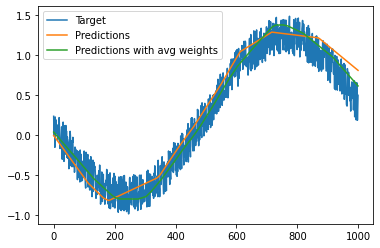

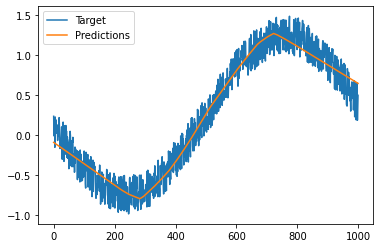

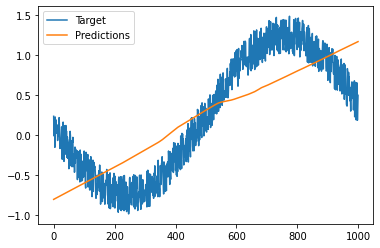

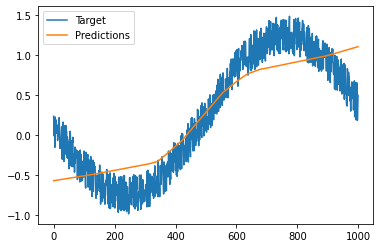

94.10205388069153 0.10220932960510254 0.06468367576599121 0.07004308700561523


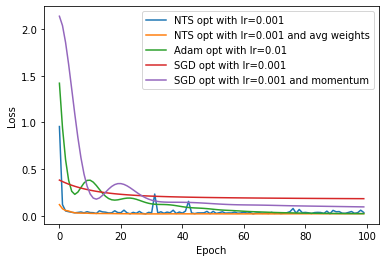

In [7]:
HIDDEN_SIZE = 50
TRAIN_SIZE = 1000
EPOCHS = 100
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-3, 3, TRAIN_SIZE), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.5*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
lrs = [1e-3, 1e-2, 1e-3, 1e-3]

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
net2 = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = torch.optim.Adam(net.parameters())
optimizer = NTS(net.parameters(), net, lr=lrs[0], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses, t, losses2 = train_net(net, loss_func, optimizer, device, x, y, True, 'nts', False, net2)

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = torch.optim.Adam(net.parameters(), lr=lrs[1])
losses_adam, t_adam = train_net(net, loss_func, optimizer, device, x, y, True)

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=lrs[2])
losses_sgd, t_sgd = train_net(net, loss_func, optimizer, device, x, y, True)

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
momentum = 0.9
optimizer = torch.optim.SGD(net.parameters(), lr=lrs[3], momentum=momentum)
losses_sgdm, t_sgdm = train_net(net, loss_func, optimizer, device, x, y, True)

plt.plot(losses, label='NTS opt with lr=' + str(lrs[0]))
plt.plot(losses2, label='NTS opt with lr=' + str(lrs[0]) + ' and avg weights')
plt.plot(losses_adam, label='Adam opt with lr=' + str(lrs[1]))
plt.plot(losses_sgd, label='SGD opt with lr=' + str(lrs[2]))
plt.plot(losses_sgdm, label='SGD opt with lr=' + str(lrs[3]) + ' and momentum')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
print(t, t_adam, t_sgd, t_sgdm)

In [0]:
# How to use:
# Choose optimizer with parameters, and create a new optimizer object
# Create new net object to train it from start, and run train_net function -
# this function return losses on train

##Сравнение метода трех квадратов с другими оптимизаторами

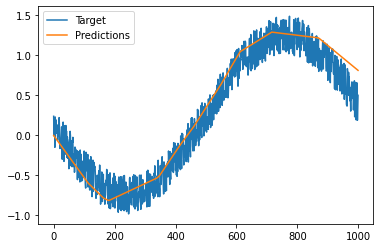

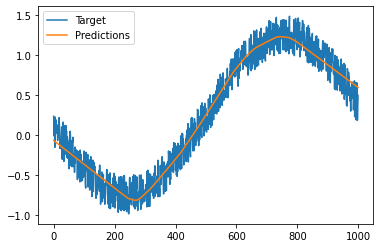

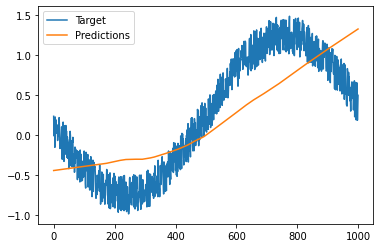

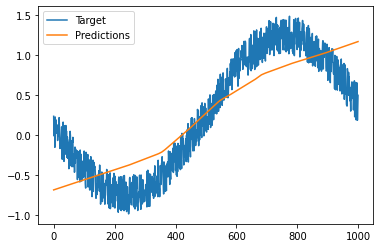

95.28835105895996 0.08755922317504883 0.06606936454772949 0.07438921928405762


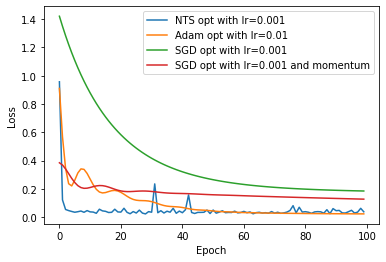

In [9]:
# set important parameters
HIDDEN_SIZE = 50
TRAIN_SIZE = 1000
EPOCHS = 100
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-3, 3, TRAIN_SIZE), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.5*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
lrs = [1e-3, 1e-2, 1e-3, 1e-3]

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
#optimizer = torch.optim.Adam(net.parameters())
optimizer = NTS(net.parameters(), net, lr=lrs[0], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses, t = train_net(net, loss_func, optimizer, device, x, y, True, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = torch.optim.Adam(net.parameters(), lr=lrs[1])
losses_adam, t_adam = train_net(net, loss_func, optimizer, device, x, y, True)

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=lrs[2])
losses_sgd, t_sgd = train_net(net, loss_func, optimizer, device, x, y, True)

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
momentum = 0.9
optimizer = torch.optim.SGD(net.parameters(), lr=lrs[3], momentum=momentum)
losses_sgdm, t_sgdm = train_net(net, loss_func, optimizer, device, x, y, True)

plt.plot(losses, label='NTS opt with lr=' + str(lrs[0]))
plt.plot(losses_adam, label='Adam opt with lr=' + str(lrs[1]))
plt.plot(losses_sgd, label='SGD opt with lr=' + str(lrs[2]))
plt.plot(losses_sgdm, label='SGD opt with lr=' + str(lrs[3]) + ' and momentum')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
print(t, t_adam, t_sgd, t_sgdm)

In [0]:
# Exp #1: show loss graphics for 200 ep
# Exp #2: show NTS convergence for diff parameters
# Exp #3: 

##Тестирование метода трех квадратов для различных параметров

###Тестирование для различных lr

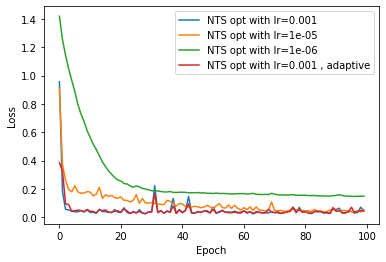

Time of work:
69.59931659698486 30.583796739578247 33.48944091796875 103.09973430633545


In [11]:
HIDDEN_SIZE = 50
TRAIN_SIZE = 1000
EPOCHS = 100
torch.manual_seed(1)
import sys
sys.setrecursionlimit(2000)
x = torch.unsqueeze(torch.linspace(-3, 3, TRAIN_SIZE), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.5*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
lrs = [1e-3, 1e-5, 1e-6, 1e-3]

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[0], adaptive_lr=False, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses, t = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[1], adaptive_lr=False, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses1, t1 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[2], adaptive_lr=False, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses2, t2 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[3], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=10, seed=42)
losses3, t3 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

plt.plot(losses, label='NTS opt with lr=' + str(lrs[0]))
plt.plot(losses1, label='NTS opt with lr=' + str(lrs[1]))
plt.plot(losses2, label='NTS opt with lr=' + str(lrs[2]))
plt.plot(losses3, label='NTS opt with lr=' + str(lrs[3]) + ' , adaptive')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('Time of work:')
print(t, t1, t2, t3)

###Сравнение различных размеров батча оптимизатора

3.856776475906372
10.251481294631958
77.74354863166809
934.5781342983246


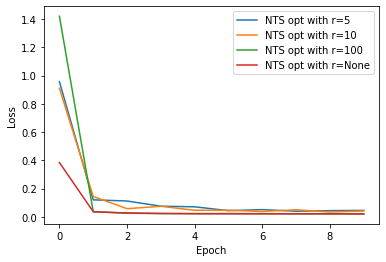

Time of work:
3.856776475906372 10.251481294631958 77.74354863166809 934.5781342983246


In [12]:
HIDDEN_SIZE = 50
TRAIN_SIZE = 1000
EPOCHS = 10
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-3, 3, TRAIN_SIZE), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.5*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
lrs = [1e-2, 1e-2, 1e-2, 1e-2]
rs = [5, 10, 100, None]

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[0], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[0], seed=42)
losses, t = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')
print(t)
net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[1], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[1], seed=42)
losses1, t1 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')
print(t1)
net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[2], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[2], seed=42)
losses2, t2 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')
print(t2)
net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[3], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[3], seed=42)
losses3, t3 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')
print(t3)
plt.plot(losses, label='NTS opt with r=' + str(rs[0]))
plt.plot(losses1, label='NTS opt with r=' + str(rs[1]))
plt.plot(losses2, label='NTS opt with r=' + str(rs[2]))
plt.plot(losses3, label='NTS opt with r=' + str(rs[3]))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('Time of work:')
print(t, t1, t2, t3)

###Сравнение для разного числа итераций во вспомогательной задаче

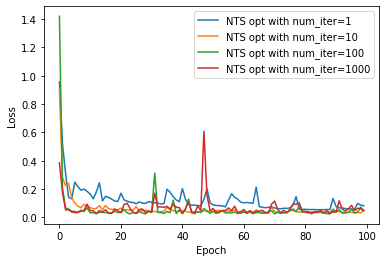

Time of work:
2.0762887001037598 5.6485559940338135 104.58844017982483 1192.509417772293


In [13]:
HIDDEN_SIZE = 50
TRAIN_SIZE = 1000
EPOCHS = 100
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-3, 3, TRAIN_SIZE), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.5*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
lrs = [1e-2, 1e-2, 1e-2, 1e-2]
rs = [10, 10, 10, 10]
ep = [1, 10, 100, 1000]

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[0], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[0], seed=42, epoch=ep[0])
losses, t = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[1], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[1], seed=42, epoch=ep[1])
losses1, t1 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[2], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[2], seed=42, epoch=ep[2])
losses2, t2 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

net = Net(n_feature=1, n_hidden=HIDDEN_SIZE, n_output=1)
optimizer = NTS(net.parameters(), net, lr=lrs[3], adaptive_lr=True, adaptive_L=True, limit_L=1e-2, r=rs[3], seed=42, epoch=ep[3])
losses3, t3 = train_net(net, loss_func, optimizer, device, x, y, False, 'nts')

plt.plot(losses, label='NTS opt with num_iter=' + str(ep[0]))
plt.plot(losses1, label='NTS opt with num_iter=' + str(ep[1]))
plt.plot(losses2, label='NTS opt with num_iter=' + str(ep[2]))
plt.plot(losses3, label='NTS opt with num_iter=' + str(ep[3]))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('Time of work:')
print(t, t1, t2, t3)